# wrangle and eda

The goal of this notebook will be to track the steps taken to collect and prepare a set of yoga pose images with the intention of training a classifier to classify new images into those poses.  The set of images used was bootstrapped with Niharika Pandit's [kaggle](https://www.kaggle.com/datasets/niharika41298/yoga-poses-dataset) submitted set and then supplmented with additional Google Image Search queries These were organinzed by subdirectory in the data/images directory.

## contents
* [imports and settings](#imports)
* [image cleanup](#cleanup)
* [resize images](#resize)
* [train test validate](#ttv)
* [generate new training samples](#gen)
* [next steps](#next)

## imports and settings<a id='imports'></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import warnings
import tensorflow as tf
import os
import cv2
import pandas as pd
import imghdr
import imagehash
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from PIL import Image

warnings.filterwarnings("ignore")
%matplotlib inline

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2023-12-08 13:45:48.184382: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-08 13:45:48.204334: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 13:45:48.204354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 13:45:48.204898: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 13:45:48.208060: I tensorflow/core/platform/cpu_feature_guar

## image cleanup<a id='cleanup'></a>

Images downloaded like this are unreliable and can be the wrong type, corrupted, badly formatted or even duplicated.  The images that can't be read in jpeg, bitmap or portable network graphics formats should be removed from the dataset.  Additional manual examination was needed to remove images with the wrongs poses, multiple examples of a pose in an image or heavily augmented images like this one.  
![tree pose with a tree](https://www.creativefabrica.com/wp-content/uploads/2022/03/02/Tree-pose-Yoga-silhouette-with-tree-Graphics-26268115-2-580x364.jpg)

In [2]:
remove = ['../data/rescaled','../data/splits']
for dir in remove:
    if os.path.exists(dir):
        shutil.rmtree(dir)

data_dir = '../data/images'
image_exts = ['jpeg','jpg']

def remove_unsuable_images (data_dir):
    removed = 0
    hash_dict = {}
    
    for image_class in os.listdir(data_dir): 
        for image in os.listdir(os.path.join(data_dir, image_class)):
            image_path = os.path.join(data_dir, image_class, image)
            
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                os.remove(image_path)
                removed+=1
                continue
            with Image.open(image_path) as img:
                img_hash = imagehash.phash(img)
                if img_hash in hash_dict:
                    os.remove(image_path)
                    removed+=1
                else:
                    hash_dict[img_hash] = image_path

    print(f'removed {removed} unusable images')

remove_unsuable_images(data_dir)

removed 0 unusable images


After these removals, the dataset contains 2,642 images in 5 classes.

In [3]:
total_files = 0
total_dirs = 0
for root, dirs, files in os.walk('../data/images'):
    total_files += len(files)
    total_dirs += len(dirs)

f'{total_files} images in {total_dirs} directories'

'2642 images in 5 directories'

Let's take a look at a random image from each class to get a general idea of the dataset.

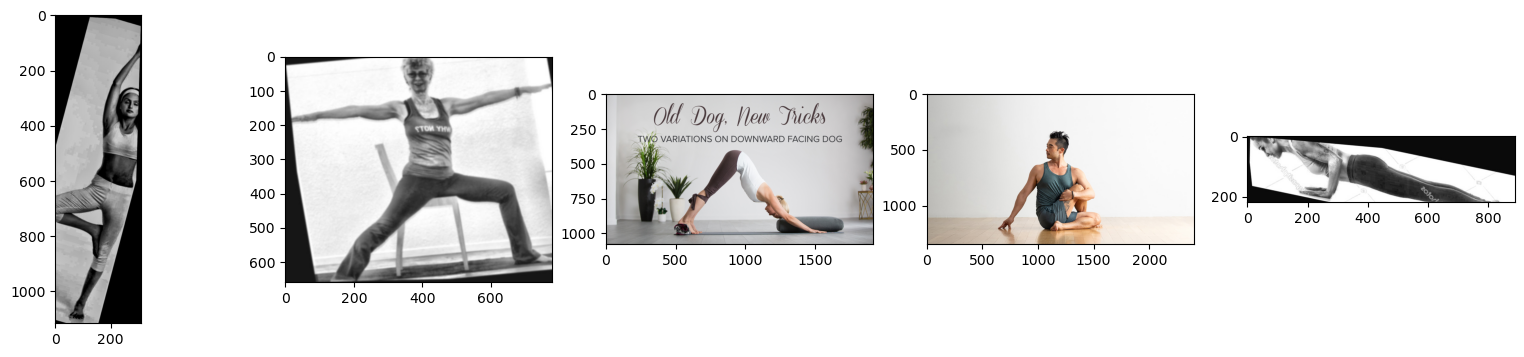

In [4]:
root_dir = '../data/images'
classes = [os.path.join(root_dir, d) for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

selected_images = []
for dir in classes:
    images = [file for file in os.listdir(dir)]
    image_path = os.path.join(dir, random.choice(images))
    selected_images.append(image_path)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Adjust the size as needed
for ax, image_path in zip(axes, selected_images):
    img = mpimg.imread(image_path)
    ax.imshow(img)
plt.show()


## resize the images<a id='resize'></a>

Most image classification models do best when the images are sized the same.  This ensures that the scale of the images is similar and the features in very large or very small images are given the same treatment.  A common selection is 255 pixels square.  Each image in the dataset was resized to 255x255.

In [5]:
def resize_images(source, dest, target_size=(255, 255)):
    os.makedirs(dest, exist_ok=True)

    for dir in os.listdir(source):
        os.makedirs(os.path.join(dest, dir), exist_ok=True)
        source_sub = os.path.join(source, dir)
        dest_sub = os.path.join(dest, dir)
        print(source_sub, dest_sub)

        for file in os.listdir(source_sub):
            in_file = os.path.join(source_sub, file)
            out_file = os.path.join(dest_sub, file)

            with Image.open(in_file) as img:
                img_rgb = img.convert('RGB')
                resized = img_rgb.resize(target_size)
                resized.save(out_file)

resize_images(data_dir, '../data/rescaled')

../data/images/Tree ../data/rescaled/Tree
../data/images/Warrior2 ../data/rescaled/Warrior2
../data/images/DownDog ../data/rescaled/DownDog
../data/images/HalfLordOfTheFishes ../data/rescaled/HalfLordOfTheFishes
../data/images/Plank ../data/rescaled/Plank


## train test validate<a id='ttv'></a>  

The next step was to create the train test and validation splits.  The 10 examples of each pose were selected at random and moved into the test folder, then 10 more of each into the validate folder.  The remaining images were moved to a training folder.  The training images will be used to train models which will be scored against the validation set with the chosen metric.  The final score of the best performing model will then be used to classify the test set for a final score.

In [6]:
def create_train_val_test_sets(root_dir, 
                               train_dir, 
                               val_dir, 
                               test_dir, 
                               holdout_size=100):
    
    for label in os.listdir(root_dir):
        label_path = os.path.join(root_dir, label)
        
        files = os.listdir(label_path)
        random.shuffle(files)
        test_images = files[:holdout_size]
        remaining_images = files[holdout_size:]
        val_images = remaining_images[:holdout_size]
        train_images = remaining_images[holdout_size:]

        for directory in [train_dir, val_dir, test_dir]:
            label_dest_path = os.path.join(directory, label)
            if not os.path.exists(label_dest_path):
                os.makedirs(label_dest_path)
                
        for img_name in val_images:
            src_path = os.path.join(label_path, img_name)
            dest_path = os.path.join(val_dir, label, img_name)
            shutil.move(src_path, dest_path)
            
        for img_name in test_images:
            src_path = os.path.join(label_path, img_name)
            dest_path = os.path.join(test_dir, label, img_name)
            shutil.move(src_path, dest_path)
            
        for img_name in train_images:
            src_path = os.path.join(label_path, img_name)
            dest_path = os.path.join(train_dir, label, img_name)
            shutil.move(src_path, dest_path)

root_dir = '../data/rescaled' 
train_dir = '../data/splits/train' 
val_dir = '../data/splits/validate' 
test_dir = '../data/splits/test'  

create_train_val_test_sets(root_dir, 
                           train_dir, 
                           val_dir, 
                           test_dir
                          )
shutil.rmtree('../data/rescaled')

As a verifcation, let's take a look at 5 images from each pose in the test and validate sets to make sure that they number 10 and depict the correct pose.

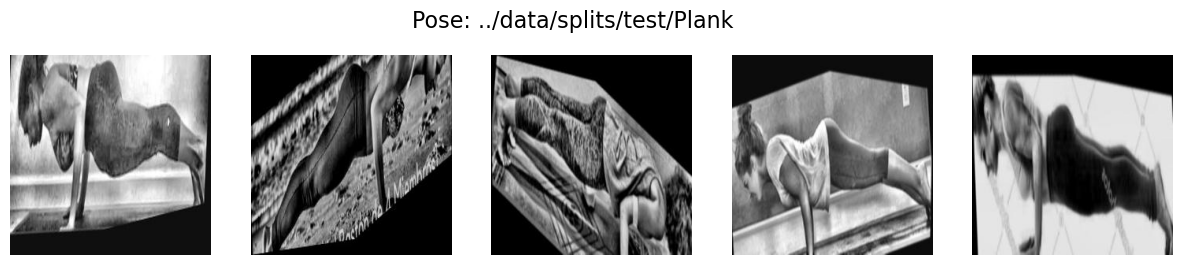

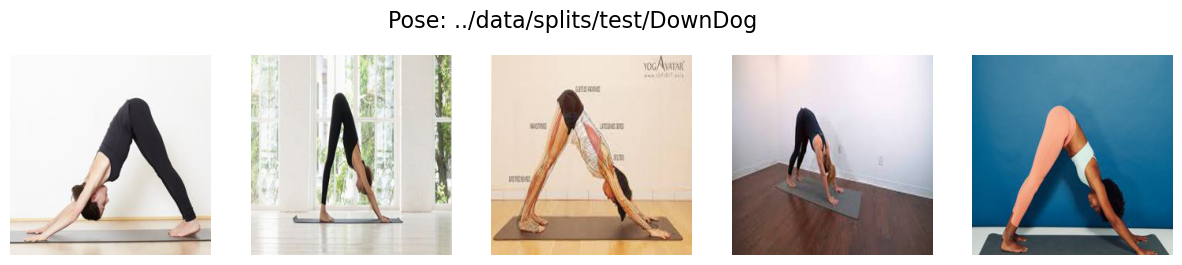

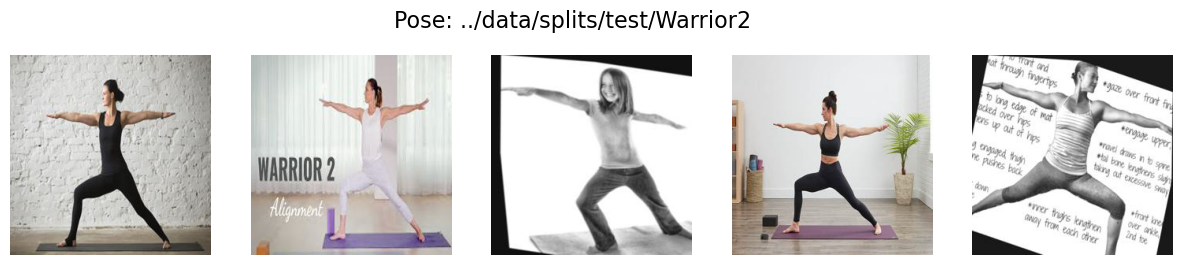

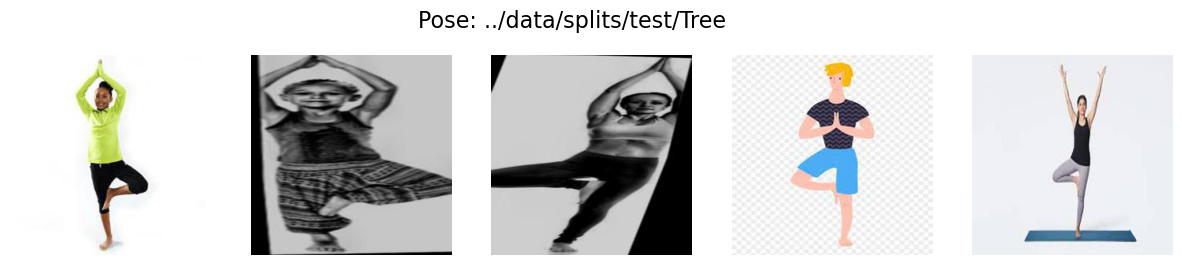

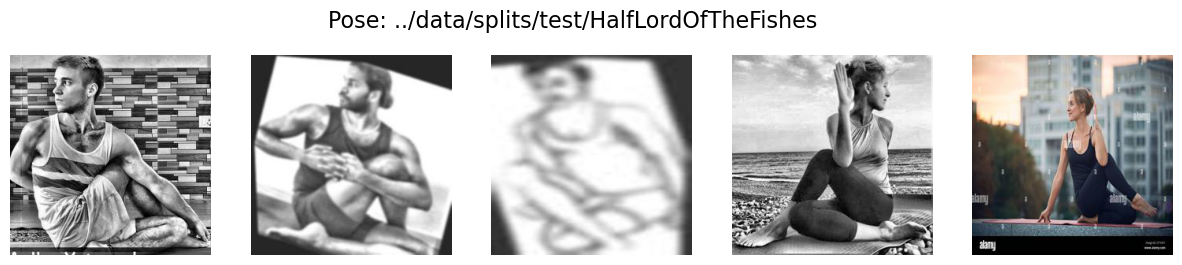

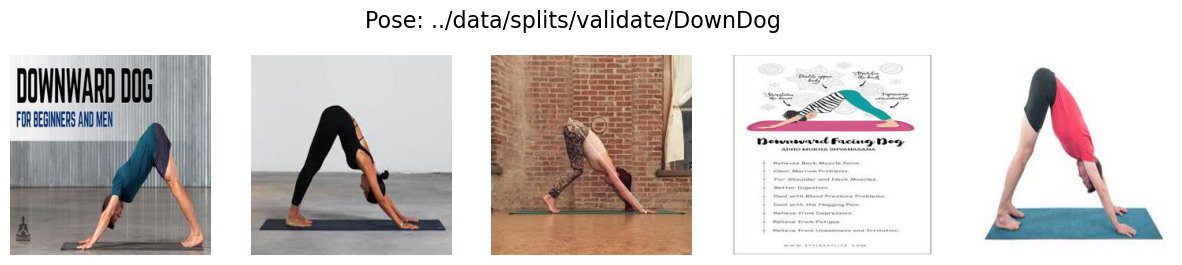

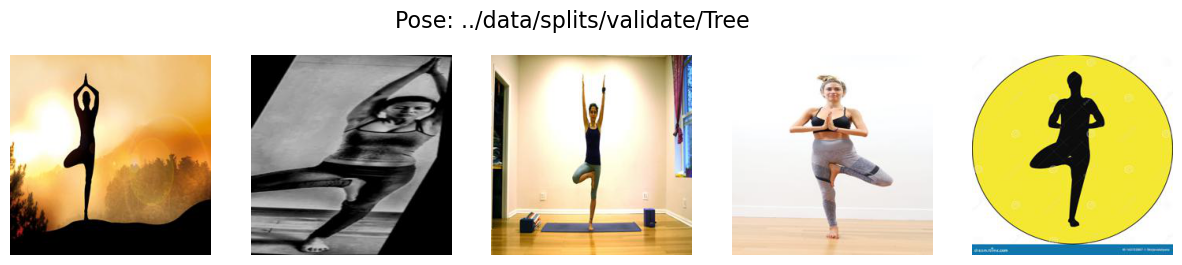

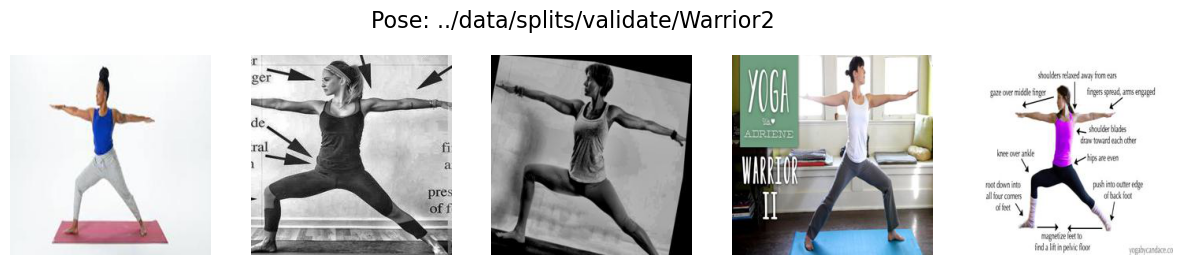

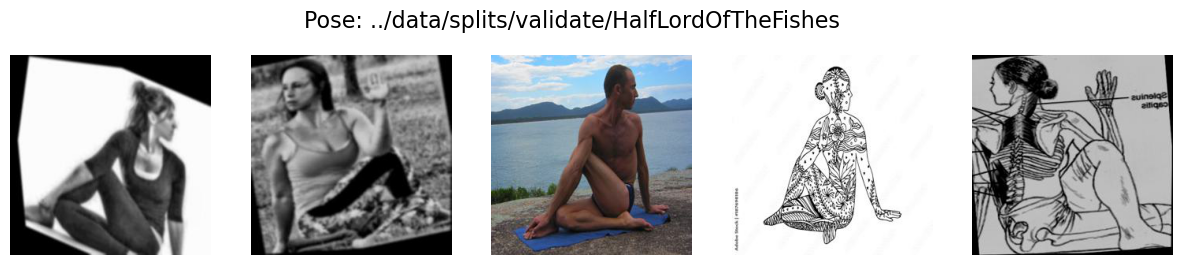

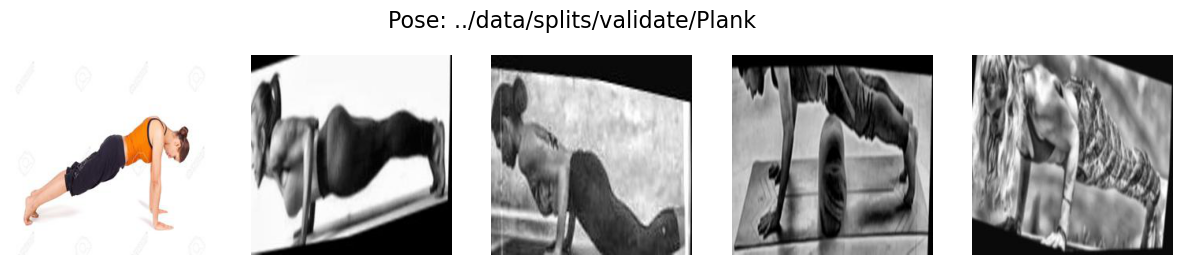

In [7]:
def display_images(root_dirs, num_images=5):
    for root_dir in root_dirs:
        folders = [os.path.join(root_dir, d) for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

        for folder in folders:
            images = [os.path.join(folder, img) for img in os.listdir(folder)]
            selected_images = random.sample(images, num_images)

            fig, axs = plt.subplots(1, num_images, figsize=(15,3))
            fig.suptitle(f'Pose: {root_dir}/{os.path.basename(folder)}', fontsize=16)

            for i, img_path in enumerate(selected_images):
                img = mpimg.imread(img_path)
                axs[i].imshow(img)
                axs[i].axis('off')

            plt.show()

score_dirs = ['../data/splits/test','../data/splits/validate']
display_images(score_dirs)

## generate new training samples<a id='gen'></a>  

Classifiers also need balanced training sets, having a similar number of examples to train from.  Imbalances in these counts could create imbalances or biases in the classifier.  Let's take a look at the current distribution.  

  

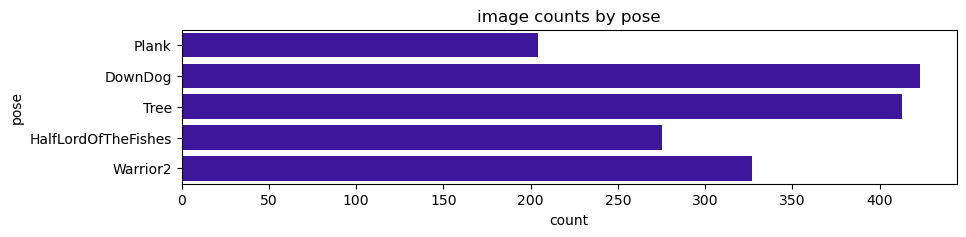

In [8]:
def class_count_hbar(root_dir):
    pose_counts = {}

    for root, dirs, files in os.walk(root_dir):
        if root == root_dir:
            continue
        folder_name = os.path.basename(root)  
        pose_counts[folder_name] = len(files)

    pose_counts = pd.DataFrame({'pose': list(pose_counts.keys()), 
                                'count': list(pose_counts.values())})
    plt.figure(figsize=(10, 2))
    sns.barplot(x='count', 
                y='pose', 
                data=pose_counts,
                color=(0.2, 0, 0.7)
               )

    plt.title('image counts by pose')
    plt.show()

class_count_hbar('../data/splits/train')


The classes are indeed wildly imbalanced and all classes should be supplmented with additional images.  I have hit a point of diminishing returns with image search, however and additional downloads yield higher percentages of unusuable or duplicate images regardless of the search terms used.  Luckily, new images can be created from the existing by performing random transformations on them.  Images from the existing training set will be selected at random, copied and then a random transformation of rotation, x or y shift, shear, zoom, flip or fill will be applied and the copy saved as a new image.  This will be repeated until all classes have 1,000 total images.

  

In [9]:
def augment_data(class_dir, target_count=1000):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    current_count = len(os.listdir(class_dir))
    image_names = os.listdir(class_dir)

    while current_count < target_count:
        image_name = np.random.choice(image_names)
        image_path = os.path.join(class_dir, image_name)
        img = load_img(image_path)
        img_array = img_to_array(img)
        img_array = img_array.reshape((1,) + img_array.shape)

        batch = datagen.flow(img_array, batch_size=1, save_to_dir=class_dir, save_prefix='aug', save_format='jpeg')
        batch.next()
        current_count = len(os.listdir(class_dir))

data_dir = '../data/splits/train'  # Replace with your actual data directory
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    augment_data(class_dir)

Each class now has 1,000 total images in the training set.

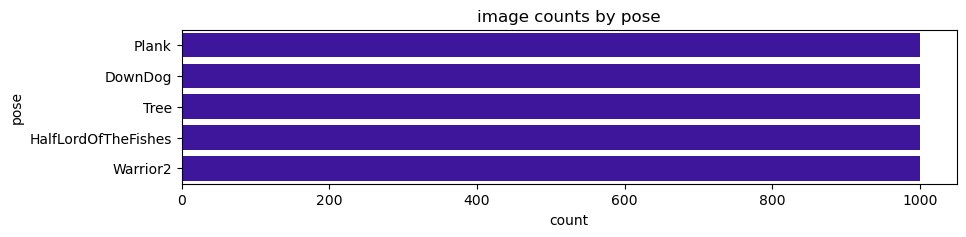

In [10]:
class_count_hbar('../data/splits/train')

As one last verification, let's check the image count in each sub directory.

In [11]:
def display_folder_structure_and_count(root_dir):
    for root, dirs, files in os.walk(root_dir):
        level = root.replace(root_dir, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/ ({len(files)} files)")

root_directory = '../data'
display_folder_structure_and_count(root_directory)


data/ (2 files)
    images/ (0 files)
        Tree/ (613 files)
        Warrior2/ (527 files)
        DownDog/ (623 files)
        HalfLordOfTheFishes/ (475 files)
        Plank/ (404 files)
    splits/ (0 files)
        test/ (0 files)
            Plank/ (100 files)
            DownDog/ (100 files)
            Warrior2/ (100 files)
            Tree/ (100 files)
            HalfLordOfTheFishes/ (100 files)
        train/ (0 files)
            Plank/ (1000 files)
            DownDog/ (1000 files)
            Tree/ (1000 files)
            HalfLordOfTheFishes/ (1000 files)
            Warrior2/ (1000 files)
        validate/ (0 files)
            DownDog/ (100 files)
            Tree/ (100 files)
            Warrior2/ (100 files)
            HalfLordOfTheFishes/ (100 files)
            Plank/ (100 files)


## next steps<a id='next'></a>

We now have clean training, test and validation data that is ready for modeling.  My plan is to decide on the desired success metric, then train a few different types of models to find the best performance.